In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import matplotlib
from itertools import product
from sklearn.neighbors import KernelDensity
from scipy.special import kl_div as kl_divergence
import matplotlib.pylab as pl
import pyrosetta as pr
pr.init("-mute core basic protocols")
matplotlib.rcParams["figure.figsize"] = (15,15)

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python37.linux 2019.45+release.fc8ab401178f6f099884fd5a39597b1a9cac8db2 2019-11-05T15:46:43] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [2]:
matplotlib.rcParams["figure.figsize"] = (10,10)

## [Visualisation] Data

In [58]:
dirname = ""
protein_names = [x.split(".")[0] for x in os.listdir(dirname + "contacts")]

ANGSTROM_BINS = np.arange(4,43,0.5)

class Protein:
    
    def __init__(self, dirname, name):
        self.name = name
        
        self.file_native = dirname + "pdb/" + name + ".pdb"
        self.native = pr.io.pose_from_pdb(dirname + "pdb/" + name + ".pdb")
        self.sequence = self.native.sequence()
        
        self.file_contacts = dirname + "contacts/" + name + ".contacts"
        self.contacts = pd.read_csv(self.file_contacts, sep=" ", names=["i", "j", "_1", "_2", "p"])[["i", "j", "p"]]
        
        self.file_photo = dirname + "photoAA_xl/" + name + "_FDR10"
        self.xl_photoAA = pd.read_csv(self.file_photo, sep=" ", names=["i", "j"])
        
        self.file_sulfo = dirname + "sulfo-SDA_xl/" + name + ".xl"
        self.xl_sulfo = pd.read_csv(self.file_sulfo, sep=" ", names=["i", "j"])
        
        self.file_numpy_dist = dirname + 'distograms/' + name + '.npz'
        self.dist_info = np.load(self.file_numpy_dist)
        
        self.file_fasta = dirname + 'fasta/' + name + '.fasta'
        self.file_map = 'mapping/' + name
        
        self.distogram = self.dist_info['distogram']
        self.ground_truth_dist = self._compute_ground_truth_dist()
        self.ground_truth_dist_clipped = self._compute_ground_truth_dist_clipped()
        
        print("Initialized " + self.name)
        
    def _compute_ground_truth_dist_clipped(self):
        return self.ground_truth_dist.clip(4,42.5)
        
        
    def _compute_ground_truth_dist(self):
        pose = self.native
        def xyz(pose,res):
        
            return pose.residue(res).xyz("N")
        residues = pose.total_residue()
        dist = np.zeros((residues,residues))
        for i, j in product(range(1,residues+1),range(1,residues+1)):
            dist[i-1,j-1] = (xyz(pose,i) - xyz(pose,j)).norm()
        
        return dist
    
    def get_mapping(self):
        with open(self.file_map,'r') as f:
            f.readline()
            ss = f.readline().strip()
            pos = 0
            mapping = np.zeros(self.ground_truth_dist.shape[1])
            for i, s in enumerate(ss):
                if s != '-':
                    mapping[pos] = i
                    pos += 1
                    
        return mapping.astype(int)
    
    def map_distogram_for_native(self,dist_2d):
        m = self.get_mapping()
        z = dist_2d[:,m]
        return z[m,:]
    
        
    @staticmethod
    def estimate_dist_argmax(dist_3d):
        return np.argmax(dist_3d,axis=0) + 4 # count starts only at four angstrom
    
    @staticmethod
    def estimate_dist_weighted(dist_3d):
        a = np.sum(ANGSTROM_BINS[:,np.newaxis] * dist_3d.reshape(dist_3d.shape[0],-1), axis=0)
        return a.reshape(int(np.sqrt(a.shape[0])),-1)
        
    def __repr__(self):
        return self.name

p = Protein(dirname, protein_names[1])

Initialized 1h7zA00


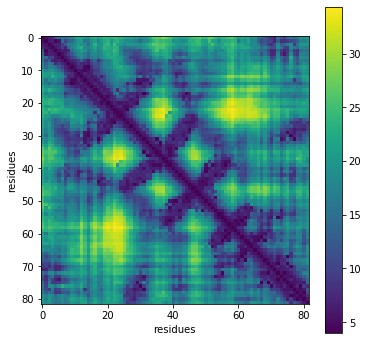

In [54]:
a = Protein.estimate_dist_weighted(p.distogram)
#a = Protein.estimate_dist_argmax(p.distogram)
#a = p.ground_truth_dist_clipped
plt.figure(figsize=(6,6))
plt.imshow(a)
plt.xlabel('residues')
plt.ylabel('residues')
plt.colorbar()

In [46]:
p.distogram

array([[[1.0000000e+00, 2.4646926e-03, 8.7486003e-03, ...,
         1.9795769e-03, 2.2694564e-03, 1.1153879e-03],
        [2.4646926e-03, 1.0000000e+00, 9.9498692e-08, ...,
         6.4150314e-03, 3.1524363e-03, 7.3128560e-04],
        [8.7486003e-03, 9.9498692e-08, 1.0000000e+00, ...,
         2.5539093e-03, 6.9660712e-03, 8.1837917e-04],
        ...,
        [1.9795769e-03, 6.4150314e-03, 2.5539093e-03, ...,
         1.0000000e+00, 1.3149225e-06, 3.1398720e-04],
        [2.2694564e-03, 3.1524363e-03, 6.9660712e-03, ...,
         1.3149225e-06, 1.0000000e+00, 1.7094511e-03],
        [1.1153879e-03, 7.3128560e-04, 8.1837917e-04, ...,
         3.1398720e-04, 1.7094511e-03, 1.0000000e+00]],

       [[2.8137167e-14, 6.4014673e-02, 2.0615764e-02, ...,
         6.1686845e-03, 5.4995697e-03, 5.3437087e-03],
        [6.4014673e-02, 1.6190497e-09, 1.8928738e-03, ...,
         3.7195273e-03, 1.0748213e-02, 3.7789969e-03],
        [2.0615764e-02, 1.8928738e-03, 8.2849491e-12, ...,
         2.494

In [47]:
def plot_contour(dist_2d, level_cnt=15,cmp=plt.cm.cool):
    if len(np.unique(dist_2d.flatten())) == 1:
        return
    
    X,Y = np.meshgrid(range(dist_2d.shape[0]),range(dist_2d.shape[1]))
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    Z = dist_2d
    levels = np.linspace(0, Z.max(), level_cnt)
    plt.contour(X, Y, Z, levels=levels, cmap=cmp)
    #plt.colorbar()

In [48]:
def scatter_sulfo(p, ax):
    sulfo = p.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1 
    ax.scatter(sulfo[:,0], sulfo[:,1], color="blue", label="Sulfo")
    ax.scatter(sulfo[:,1], sulfo[:,0], color="blue")
    
def scatter_photo(p, ax):
    photoAA = p.xl_photoAA[["i", "j"]].values.astype(np.int32) - 1
    plt.scatter(photoAA[:,0], photoAA[:,1], color="red", label="photoAA")
    plt.scatter(photoAA[:,1], photoAA[:,0], color="red")

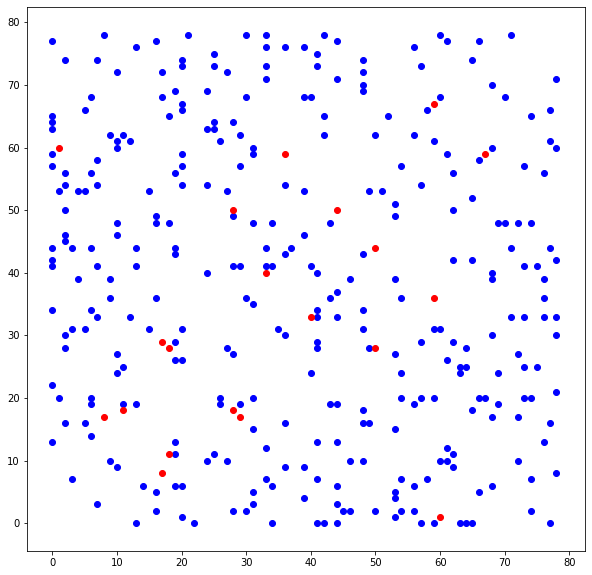

In [49]:
ax = plt.gca()
scatter_sulfo(p,ax)
scatter_photo(p,ax)

## [Method]:1 Convolve knowledge about existing contacts to nearby residues

In [59]:
def calc_distance_estimation_sulfo(p,bandwidth=3,kernel='gaussian'):
    residues = range(p.distogram.shape[1])
    sulfo = p.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1
    sulfo_all = np.vstack((sulfo,np.vstack((sulfo[:,1],sulfo[:,0])).T))
    if sulfo_all.shape[0] == 0:
        print('not sulfo Xlinks available')
        return np.zeros((len(residues),len(residues)))
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(sulfo_all)
    X,Y = np.meshgrid(residues,residues)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    return np.exp(kde.score_samples(xy).reshape(len(residues),len(residues)))

def calc_distance_estimation_photo(p,bandwidth=3,kernel='gaussian'):
    residues = range(p.distogram.shape[1])
    photo = p.xl_photoAA[["i", "j"]].values.astype(np.int32) - 1
    photo_all = np.vstack((photo,np.vstack((photo[:,1],photo[:,0])).T))
    if photo_all.shape[0] == 0:
        print('not photo Xlinks available')
        return np.zeros(len(residues),len(residues))
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(photo_all)
    X,Y = np.meshgrid(residues,residues)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    return np.exp(kde.score_samples(xy).reshape(len(residues),len(residues)))


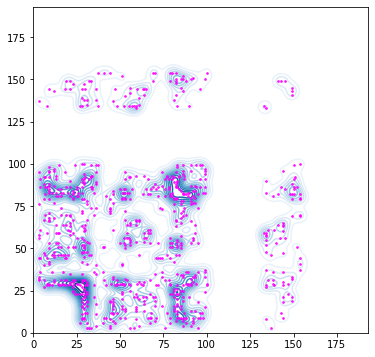

In [95]:
plt.figure(figsize=(6,6))
plot_contour(calc_distance_estimation_sulfo(p),cmp=plt.cm.Blues)
#scatter_sulfo(p,plt.gca())
ax=plt.gca()
sulfo = p.xl_sulfo[["i", "j"]].values.astype(np.int32) - 1 
ax.scatter(sulfo[:,0], sulfo[:,1], color="magenta",s=3,zorder=5,alpha=0.8)
ax.scatter(sulfo[:,1], sulfo[:,0], color="magenta",s=3,zorder=5,alpha=0.8)

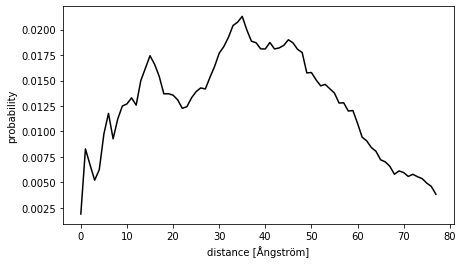

In [61]:
plt.figure(figsize=(7,4))
plt.xlabel('distance [Ångström]')
plt.ylabel('probability')
#plt.plot(p.distogram[:,3,10],c='black')
plt.plot(p.distogram[:,3,29],c='black')

## [Method]:2 Combine predicted histogram with contact-derived 2d-<25Å distribution

##### Find good functions for spreading the probability distribution

In [62]:
#show the experimentally derived curves
additive_photo = np.load("dist_close.npy")
additive_sulfo = np.load("dist_medium.npy")

##### Combine the 3d-crosslink distribution with the original prediction

In [73]:
# magically convert 2d to 3d via the above function and some addition
def adapt_for_greater_than(dist, sulfo_Z, photo_Z, alpha_sulfo=10000, alpha_photo=10000):
    add = np.tile(additive_photo.reshape((-1, 1, 1)), (1, dist.shape[1], dist.shape[2]))
    weighted_add = photo_Z.reshape(-1, photo_Z.shape[0], photo_Z.shape[1]) * add * alpha_photo * 0
    dist_ = dist + weighted_add
    dist = dist_ / dist_.sum(axis=0)
    
    add = np.tile(additive_sulfo.reshape((-1, 1, 1)), (1, dist.shape[1], dist.shape[2]))
    weighted_add = sulfo_Z.reshape(-1, sulfo_Z.shape[0], sulfo_Z.shape[1]) * add * alpha_sulfo
    dist_ = dist + weighted_add
    dist_ /= dist_.sum(axis=0)
    
    return dist_

In [74]:
# putting it all together
new_distribution = adapt_for_greater_than(p.distogram, 
                                          calc_distance_estimation_sulfo(p), 
                                          calc_distance_estimation_photo(p))

##### Visualisation of the impact of this process

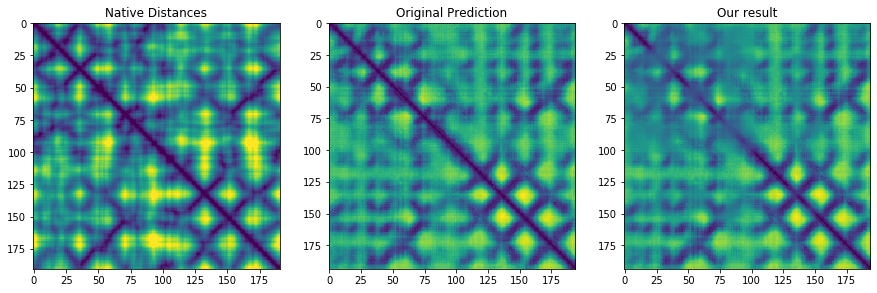

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))

# native
ax1.imshow(p.ground_truth_dist_clipped)
ax1.set_title('Native Distances')

# original distogram
ax2.imshow(Protein.estimate_dist_weighted(p.distogram))
#scatter_sulfo(p,ax2)
ax2.set_title('Original Prediction')

# new distogram 
ax3.imshow(Protein.estimate_dist_weighted(new_distribution))
ax3.set_title('Our result');

# [Evaluation]

In [69]:
# set up various methods to create new distograms

def no_dist_update(p):
    return p.distogram

def vanialla_conversion(p):
    return adapt_for_greater_than(p.distogram, 
                                  calc_distance_estimation_sulfo(p), 
                                  calc_distance_estimation_photo(p))

methods = [(f.__name__, f) for f in [no_dist_update, vanialla_conversion]]
ps = [Protein(dirname, name) for name in protein_names]

Initialized 3frkA02
Initialized 1h7zA00
Initialized 4fqdA01
Initialized 1i1nA00
Initialized 4ebjA02
Initialized 2xp1A02
Initialized 3esiA00
Initialized 4k30A00
Initialized 1e2uA04
Initialized 1knwA02
Initialized 4ic1A00
Initialized 3t30C00
Initialized 4htlA02


## [Evaluation]:1 Accuracy of distogram

In [14]:
# todo: 
# - measure how much change we actually introduced in the 3d distribution (KL-div)
# - compare two 2D distributions (mse? KL-div)
def jensen(a,b):
    return np.sqrt((kl_divergence(a,b) + kl_divergence(b,a))/2)

In [15]:
results_distogram = []
for p, func in product(ps, methods):
    m, func = func
    d = func(p)
    
    dist_orig_2d = p.map_distogram_for_native(Protein.estimate_dist_weighted(p.distogram))
    dist_new_2d = p.map_distogram_for_native(Protein.estimate_dist_weighted(d))
    r = {}                           
    r['new_vs_orig_j'] = np.mean(jensen(d, p.distogram))
    r['true_vs_orig_j'] = np.mean(jensen(dist_orig_2d, p.ground_truth_dist_clipped))
    r['true_vs_new'] = np.mean(jensen(dist_new_2d, p.ground_truth_dist_clipped))
    r['name'] = p.name
    r['method'] = m
    results_distogram.append(r)              
df_dist = pd.DataFrame(results_distogram)    

/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value en

not sulfo Xlinks available


/home/freya/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


In [16]:
df_dist.head()

,new_vs_orig_j,true_vs_orig_j,true_vs_new,name,method
0,0.0,0.461186,0.461186,3frkA02,no_dist_update
1,NaN,0.461186,0.450199,3frkA02,vanialla_conversion
2,0.0,0.740633,0.740633,1h7zA00,no_dist_update
3,NaN,0.740633,0.735990,1h7zA00,vanialla_conversion
4,0.0,0.576425,0.576425,4fqdA01,no_dist_update


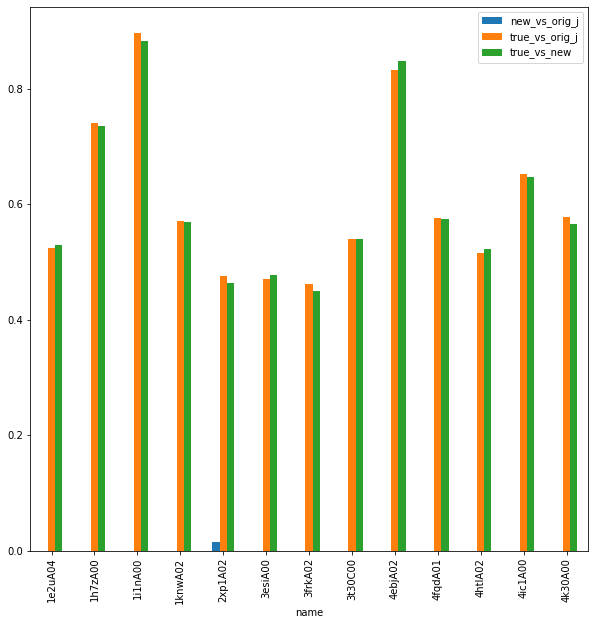

In [17]:
g = df_dist[df_dist.method == 'vanialla_conversion'].groupby('name').mean()
g.plot(kind='bar')

## [Evaluation]:2 Improvement in Minimisation 

In [18]:
import sys, os

def save_to_rosetta_format_cmd(p, distogram_file, outname):
    # for converting to rosetta
    python = sys.executable
    snippet = 'code/distograms_to_rosetta.py'
    params = ' '.join(['--prediction', distogram_file, 
    '--fasta',  p.file_fasta, 
    '--cst_folder', 'our_dist_cst/' + outname.replace('.','_'),
    '--cst_file', 'our_dist_cst/' + outname ])
    return ' '.join([python, snippet, params])


def minimize_cmd(p, dist_numpy,dist_file_rosetta, outname):
    python = sys.executable
    snippet = "minimize.py"
    params = ' '.join(['--fasta', p.file_fasta, 
    '--prediction', dist_numpy,
    '--mapping' , p.file_map,
    '--native', p.file_native,
    '--output', outname,
    '--constraint', 'our_dist_cst/' + dist_file_rosetta
                      ])
    return ' '.join([python, snippet, params])

def minimize_cmd_WRONG(p, dist_numpy,dist_file_rosetta, outname):
    python = sys.executable
    snippet = "minimize.py"
    params = ' '.join(['--fasta', p.file_fasta, 
    '--prediction', p.file_numpy_dist,
    '--mapping' , p.file_map,
    '--native', p.file_native,
    '--output', outname])
    return ' '.join([python, snippet, params])


def save_all(p,new_dist,numpy_dist_name):
    np.savez(numpy_dist_name, 
             distogram=new_dist, 
             ss=p.dist_info['ss'], 
             phi=p.dist_info['phi'], 
             phi_kappa=p.dist_info['phi_kappa'] , 
             psi=p.dist_info['psi'] , 
             psi_kappa=p.dist_info['ss'])

In [19]:
# generate the commands only for the minimize.py script
to_be_run = []

for p, func in product(ps, methods):
    experiment_name, func = func
    d = func(p)
    
    # when we want to use our new distogram in the minimisation, 
    # we need to update the numpy and rosetta-constraint files
    dist_file_rosetta = p.name + '_testrun.cst'
    dist_file_numpy = 'our_distogram/'+ p.name +'_testrun.npz'

    # also give a name to the output file of our result
    outname = 'our_results/'  + experiment_name +  '.' + p.name + '.pdb'

    # this will take about 15-20mins
    save_all(p,d,dist_file_numpy)
    cmd1 = save_to_rosetta_format_cmd(p,dist_file_numpy, dist_file_rosetta)
    cmd2 = minimize_cmd(p,dist_file_numpy,dist_file_rosetta, outname)
    
    to_be_run.append((experiment_name, cmd1,cmd2))
    

not sulfo Xlinks available


##### Actually run the commands

In [20]:
for i, cmd in enumerate(to_be_run):
    # execute 
    if i == 2:
        break
    
    name, cmd1, cmd2 = cmd
    print("%s: Start Rosetta conversion" % i)
    !{cmd1}
    print("%s: Start Minimisation" % i)
    !{cmd2}

0: Start Rosetta conversion
0: Start Minimisation
PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python37.linux 2019.45+release.fc8ab401178f6f099884fd5a39597b1a9cac8db2 2019-11-05T15:46:43] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
fasta/3frkA02.fasta 5.8427886962890625 131635.31548273857 954.9995697931804
1: Start Rosetta conversion
1: Start Minimisation
PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python37.linux 2019.45+release.fc8ab401178f6f099884fd5a39597b1a9cac8db2 2019-11-05T15:46:43] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
fasta/3frkA02.fasta 10.827574729919434 135498.58849963298 1586.5045744375386


In [21]:
result_dir = 'our_results'
results = []
for filename in os.listdir(result_dir):
    if filename.endswith(".args"):
        exp = filename.split('.')[0]
        with open(os.path.join(result_dir ,filename),'r') as f:
            f.readline()
            f.readline()
            r = f.readline().split(',')
            r[0] = r[0].split('/')[-1].split('.')[0]
        res = dict(zip(['fasta','rsmd', 'fa1','fa2','seconds'],r))
        res['method'] = exp
        res['rsmd'] = float(res['rsmd'])
        res['fa1'] = float(res['fa1'])
        res['fa2'] = float(res['fa2'])
        try:
            res['seconds'] = float(res['seconds'])
        except:
            pass
        
        results.append(res)
        
df = pd.DataFrame(results)
df

,fasta,rsmd,fa1,fa2,seconds,method
0,3frkA02,10.827575,135498.588500,1586.504574,210.506833,vanialla_conversion
1,3frkA02,19.755825,-144.930913,-144.930913,62.779486,no_dist_update
2,3frkA02,15.902087,-155.210572,-155.210572,30.363250,no_dist_update
3,3frkA02,18.783585,-199.575507,-199.575507,66.258950,example_dist_update
4,3frkA02,17.340862,-179.302793,-179.302793,NaN,no_dist_update
5,3frkA02,15.370193,-140.984263,-140.984263,NaN,example_dist_update
6,3frkA02,5.842789,131635.315483,954.999570,443.934828,no_dist_update
7,3frkA02,19.379135,-166.181818,-166.181818,61.528703,example_dist_update
